# Set up basic

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout, LSTMCell, RNN, Reshape
from keras.callbacks import EarlyStopping
from keras import initializers, Model
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
# import plotly.offline as py
# import plotly.graph_objs as go
# py.init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
data = pd.read_csv('/Users/yuhaoli/code/HowardLiYH/Volatility-prediction/datasets/raw/data_0401(6hrs).csv')
data.columns = ['scrape_time','lastUpdateId','bp_1','bz_1','bp_2','bz_2','bp_3','bz_3','bp_4','bz_4','bp_5','bz_5','bp_6','bz_6','bp_7','bz_7','bp_8','bz_8','bp_9','bz_9','bp_10','bz_10','bp_11','bz_11','bp_12','bz_12','bp_13','bz_13','bp_14','bz_14','bp_15','bz_15','bp_16','bz_16','bp_17','bz_17','bp_18','bz_18','bp_19','bz_19','bp_20','bz_20','ap_1','az_1','ap_2','az_2','ap_3','az_3','ap_4','az_4','ap_5','az_5','ap_6','az_6','ap_7','az_7','ap_8','az_8','ap_9','az_9','ap_10','az_10','ap_11','az_11','ap_12','az_12','ap_13','az_13','ap_14','az_14','ap_15','az_15','ap_16','az_16','ap_17','az_17','ap_18','az_18','ap_19','az_19','ap_20','az_20']
data.drop(['lastUpdateId'], axis=1, inplace= True)

In [3]:
## Drop scrape_time and create scrape_time_diff

data['scrape_time_interval'] = pd.to_datetime(data['scrape_time']).diff().dt.total_seconds()
data.drop(['scrape_time'], axis=1, inplace= True)

In [4]:
##################### Basic Feature Creation ##################
### Weighted Average Price 
data['WAP'] = (data['bp_1']*data['bz_1']
               +data['bp_2']*data['bz_2']
               +data['ap_1']*data['az_1']
               +data['ap_2']*data['az_2'])/(data['bz_1']+
                                         data['bz_2']+
                                         data['az_1']+
                                         data['az_2'])

#### Spread
data['spread'] = ((data['ap_1']/data['bp_1']) - 1)

### Log price
def log_price(list_stock_prices):
    return np.log(list_stock_prices)

data.insert(0, 'log_price', log_price(data['WAP']))

### Log returns
data['log_returns'] = data.log_price.diff()

### Realized Volatility
def realized_volatility():
    list_vol = []
    i = 0
    for i in data.index:
        x = np.std(data.log_returns.iloc[:i])
        i += 1
        list_vol.append(x)
    
    return list_vol

data['realized_volatility'] = realized_volatility()

### Future volatility
data['volatility_t+1'] = data['realized_volatility'].shift(-1)

### Bid quantities
data['bid depth'] = data[['bz_1', 'bz_2', 'bz_3','bz_4', 'bz_5', 'bz_6','bz_7', 'bz_8', 'bz_9','bz_10',
                         'bz_11', 'bz_12', 'bz_13','bz_14', 'bz_15', 'bz_16','bz_17', 'bz_18', 'bz_19','bz_20']].sum(axis=1)


#sum of all bid quantities
data['ask depth'] = data[['az_1', 'az_2', 'az_3','az_4', 'az_5', 'az_6','az_7', 'az_8', 'az_9','az_10',
                         'az_11', 'az_12', 'az_13','az_14', 'az_15', 'az_16','az_17', 'az_18', 'az_19','az_20']].sum(axis=1)

In [5]:
df = data.copy()

In [6]:
data.drop(['bp_1','bp_2','bp_3','bp_4','bp_5','bp_6','bp_7','bp_8','bp_9','bp_10','bp_11','bp_12','bp_13','bp_14','bp_15','bp_16','bp_17','bp_18','bp_19','bp_20',
          'bz_1','bz_2','bz_3','bz_4','bz_5','bz_6','bz_7','bz_8','bz_9','bz_10','bz_11','bz_12','bz_13','bz_14','bz_15','bz_16','bz_17','bz_18','bz_19','bz_20',
          'ap_1','ap_2','ap_3','ap_4','ap_5','ap_6','ap_7','ap_8','ap_9','ap_10','ap_11','ap_12','ap_13','ap_14','ap_15','ap_16','ap_17','ap_18','ap_19','ap_20',
            'az_1','az_2','az_3','az_4','az_5','az_6','az_7','az_8','az_9','az_10','az_11','az_12','az_13','az_14','az_15','az_16','az_17','az_18','az_19','az_20'],axis=1, inplace=True)
          

In [7]:
data = data.iloc[3:-1,:].reset_index()
data.drop(['index'], axis=1, inplace= True)

df = df.iloc[3:-1,:].reset_index()
df.drop(['index'], axis=1, inplace= True)

# Creation

In [8]:
# 1. ob_weighted_price
def weighted_price(bid_prices, ask_prices, bid_sizes, ask_sizes):
    total_size = sum(bid_sizes) + sum(ask_sizes)
    if total_size == 0:
        return None
    bid_sum = sum([bid_prices[i] * bid_sizes[i] for i in range(len(bid_prices))])
    ask_sum = sum([ask_prices[i] * ask_sizes[i] for i in range(len(ask_prices))])
    return (bid_sum + ask_sum) / total_size

ob_weighted_price_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    ob_weighted_price = weighted_price(bid_prices, ask_prices, bid_sizes, ask_sizes)
    ob_weighted_price_list.append(ob_weighted_price)
    
data['ob_weighted_price'] = ob_weighted_price_list

In [9]:
# 2. EMA
# 3. SMA

SMA_list = []
EMA_list = []


for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    closing_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    
    # Calculate a 12-period simple moving average
    periods = 12
    sma = np.mean(closing_prices[-periods:])
    SMA_list.append(sma)
    
    # Create a pandas DataFrame with the closing prices
    df_ema = pd.DataFrame({"Close": closing_prices})
    ema = df_ema["Close"].ewm(span=periods, adjust=False).mean().iloc[-1]
    EMA_list.append(ema)


data['SMA'] = SMA_list
data['EMA'] = EMA_list

In [10]:
# 4. TWAP


TWAP_list = []

for index, row in df.iterrows():
    test_df = df.iloc[index,:]
    bid_prices = [test_df[1],test_df[3],test_df[5],test_df[7],test_df[9],test_df[11],test_df[13],test_df[15],test_df[17],test_df[19],test_df[21],test_df[23],test_df[25],test_df[27],test_df[29],test_df[31],test_df[33],test_df[35],test_df[37],test_df[39]]
    ask_prices = [test_df[41],test_df[43],test_df[45],test_df[47],test_df[49],test_df[51],test_df[53],test_df[55],test_df[57],test_df[59],test_df[61],test_df[63],test_df[65],test_df[67],test_df[69],test_df[71],test_df[73],test_df[75],test_df[77],test_df[79]]
    bid_sizes = [test_df[2],test_df[4],test_df[6],test_df[8],test_df[10],test_df[12],test_df[14],test_df[16],test_df[18],test_df[20],test_df[22],test_df[24],test_df[26],test_df[28],test_df[30],test_df[32],test_df[34],test_df[36],test_df[38],test_df[40]]
    ask_sizes = [test_df[42],test_df[44],test_df[46],test_df[48],test_df[50],test_df[52],test_df[54],test_df[56],test_df[58],test_df[60],test_df[62],test_df[64],test_df[66],test_df[68],test_df[70],test_df[72],test_df[74],test_df[76],test_df[78],test_df[80]]
    
    total_bid_volume = sum(bid_sizes)
    total_ask_volume = sum(ask_sizes)

    # Initialize variables for TWAP calculation
    twap_numerator = 0
    twap_denominator = 0
    time_interval = 60  # in seconds
    total_time = time_interval * len(bid_prices)

    # Calculate TWAP
    for i in range(len(bid_prices)):
        mid_price = (bid_prices[i] + ask_prices[i]) / 2
        volume = min(bid_sizes[i], ask_sizes[i])
        twap_numerator += mid_price * volume * time_interval
        twap_denominator += volume * time_interval

    TWAP = twap_numerator / twap_denominator
    TWAP_list.append(TWAP)
    
data['TWAP'] = TWAP_list

In [11]:
# 5. price_level
data['price_level'] = (df['bp_1'] + df['ap_1'])/2

# LSTM

In [55]:
X = data.drop(['realized_volatility','volatility_t+1','log_price', 'spread', 'ask depth',], axis=1)
y = np.expand_dims(data['volatility_t+1'].values, 1)


In [56]:
scaler = MinMaxScaler().fit(X)
X_scaled = scaler.transform(X)
X_scaled.shape

(9169, 9)

In [57]:
def convert2matrix(X_arr,Y_arr, look_back=12):
    X, Y =[], []
    #iterating thorough the data with window as look back
    for i in range(len(X_arr)-look_back):
        d=i+look_back 
        # extracting the X as features and target of n days and Y as   target at (n+1)th day
        X.append(np.hstack((X_arr[i:d],Y_arr[i:d])))
        Y.append(Y_arr[d])
    return np.array(X), np.array(Y)

In [58]:
X_new, y_new = convert2matrix(X_scaled, y)
print(X_new.shape, y_new.shape) 
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, shuffle=False)

(9157, 12, 10) (9157, 1)


In [59]:
model = Sequential()
model.add(LSTM(128, return_sequences=False, input_shape=(X_new.shape[1], X_new.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

In [60]:
model.compile(loss='mse', optimizer=Adam(0.01), metrics=['mape'])
history = model.fit(X_train, y_train, epochs=500, batch_size=64, shuffle=True,
                    validation_split=0.4,
                    callbacks = 
                    [EarlyStopping(patience=50, verbose=1)])

Epoch 1/500
61/61 [==============================] - 2s 10ms/step - loss: 0.0364 - mape: 207670.4688 - val_loss: 7.4898e-05 - val_mape: 22514.9961
Epoch 2/500
61/61 [==============================] - 0s 7ms/step - loss: 2.5642e-04 - mape: 33970.6602 - val_loss: 4.2297e-05 - val_mape: 14598.5332
Epoch 3/500
61/61 [==============================] - 0s 7ms/step - loss: 1.5659e-04 - mape: 26466.9883 - val_loss: 2.3449e-05 - val_mape: 10071.3252
Epoch 4/500
61/61 [==============================] - 0s 7ms/step - loss: 1.0904e-04 - mape: 22353.8691 - val_loss: 2.1604e-05 - val_mape: 9285.5332
Epoch 5/500
61/61 [==============================] - 0s 7ms/step - loss: 7.5527e-05 - mape: 18425.0742 - val_loss: 3.4928e-05 - val_mape: 12711.4092
Epoch 6/500
61/61 [==============================] - 0s 7ms/step - loss: 5.7562e-05 - mape: 16027.5283 - val_loss: 1.5835e-05 - val_mape: 7822.4282
Epoch 7/500
61/61 [==============================] - 0s 7ms/step - loss: 4.1147e-05 - mape: 13560.0908 - val_l

61/61 [==============================] - 0s 7ms/step - loss: 2.1414e-06 - mape: 3020.6699 - val_loss: 5.2023e-07 - val_mape: 1392.2554
Epoch 57/500
61/61 [==============================] - 0s 7ms/step - loss: 1.9520e-06 - mape: 2889.5664 - val_loss: 7.7444e-07 - val_mape: 2123.4587
Epoch 58/500
61/61 [==============================] - 0s 7ms/step - loss: 2.2325e-06 - mape: 3151.3533 - val_loss: 2.5508e-06 - val_mape: 4300.9492
Epoch 59/500
61/61 [==============================] - 0s 7ms/step - loss: 1.7913e-06 - mape: 2721.1780 - val_loss: 3.9529e-07 - val_mape: 1209.7069
Epoch 60/500
61/61 [==============================] - 0s 7ms/step - loss: 1.6102e-06 - mape: 2541.4136 - val_loss: 6.5566e-07 - val_mape: 1942.2948
Epoch 61/500
61/61 [==============================] - 0s 7ms/step - loss: 1.9011e-06 - mape: 2868.6060 - val_loss: 5.3109e-07 - val_mape: 1646.9080
Epoch 62/500
61/61 [==============================] - 0s 7ms/step - loss: 1.6224e-06 - mape: 2619.4744 - val_loss: 6.4152e-07

61/61 [==============================] - 0s 7ms/step - loss: 4.1436e-06 - mape: 4403.1079 - val_loss: 2.4358e-07 - val_mape: 1195.7142
Epoch 112/500
61/61 [==============================] - 0s 7ms/step - loss: 7.8225e-07 - mape: 1896.9257 - val_loss: 1.5354e-06 - val_mape: 3461.2932
Epoch 113/500
61/61 [==============================] - 0s 7ms/step - loss: 5.0898e-07 - mape: 1488.9156 - val_loss: 9.2511e-08 - val_mape: 549.1084
Epoch 114/500
61/61 [==============================] - 0s 7ms/step - loss: 9.7228e-07 - mape: 2120.6768 - val_loss: 1.6362e-07 - val_mape: 927.2671
Epoch 115/500
61/61 [==============================] - 0s 7ms/step - loss: 5.6836e-07 - mape: 1639.1036 - val_loss: 1.0404e-06 - val_mape: 2821.4272
Epoch 116/500
61/61 [==============================] - 0s 7ms/step - loss: 1.3224e-06 - mape: 2533.3235 - val_loss: 5.7189e-06 - val_mape: 6771.6777
Epoch 117/500
61/61 [==============================] - 0s 7ms/step - loss: 2.3682e-06 - mape: 3495.9099 - val_loss: 2.7950

61/61 [==============================] - 0s 7ms/step - loss: 7.6265e-08 - mape: 582.4247 - val_loss: 8.0858e-08 - val_mape: 679.2209
Epoch 167/500
61/61 [==============================] - 0s 7ms/step - loss: 5.5650e-08 - mape: 491.8063 - val_loss: 5.3444e-07 - val_mape: 2048.9041
Epoch 168/500
61/61 [==============================] - 0s 7ms/step - loss: 5.7210e-07 - mape: 1731.3048 - val_loss: 2.4093e-07 - val_mape: 1354.6403
Epoch 169/500
61/61 [==============================] - 0s 7ms/step - loss: 2.6515e-07 - mape: 1148.1169 - val_loss: 3.0150e-08 - val_mape: 338.8842
Epoch 170/500
61/61 [==============================] - 0s 7ms/step - loss: 1.8016e-07 - mape: 950.7160 - val_loss: 8.7893e-08 - val_mape: 766.2578
Epoch 171/500
61/61 [==============================] - 0s 7ms/step - loss: 2.1618e-07 - mape: 932.4172 - val_loss: 1.2604e-07 - val_mape: 953.5226
Epoch 172/500
61/61 [==============================] - 0s 7ms/step - loss: 1.7179e-07 - mape: 897.0176 - val_loss: 6.5665e-07 - 

61/61 [==============================] - 0s 7ms/step - loss: 1.5341e-07 - mape: 822.8091 - val_loss: 1.9196e-08 - val_mape: 339.2950
Epoch 222/500
61/61 [==============================] - 0s 7ms/step - loss: 3.8070e-08 - mape: 424.6200 - val_loss: 1.2889e-08 - val_mape: 293.4148
Epoch 223/500
61/61 [==============================] - 0s 7ms/step - loss: 1.3574e-08 - mape: 257.3009 - val_loss: 3.9169e-09 - val_mape: 123.3517
Epoch 224/500
61/61 [==============================] - 0s 7ms/step - loss: 4.9562e-08 - mape: 459.7368 - val_loss: 3.0422e-07 - val_mape: 1561.3534
Epoch 225/500
61/61 [==============================] - 0s 7ms/step - loss: 9.1263e-08 - mape: 632.4360 - val_loss: 5.0549e-09 - val_mape: 177.5508
Epoch 226/500
61/61 [==============================] - 0s 7ms/step - loss: 7.0408e-08 - mape: 629.6054 - val_loss: 1.6853e-08 - val_mape: 347.5904
Epoch 227/500
61/61 [==============================] - 0s 8ms/step - loss: 7.8359e-08 - mape: 643.7562 - val_loss: 5.9191e-09 - val

Epoch 277/500
61/61 [==============================] - 0s 8ms/step - loss: 1.1225e-05 - mape: 6339.2026 - val_loss: 0.0678 - val_mape: 46945.7656
Epoch 278/500
61/61 [==============================] - 0s 8ms/step - loss: 1.0484e-05 - mape: 5984.7998 - val_loss: 0.0672 - val_mape: 46768.6641
Epoch 279/500
61/61 [==============================] - 0s 8ms/step - loss: 1.0766e-05 - mape: 5933.3999 - val_loss: 0.0666 - val_mape: 46074.3477
Epoch 280/500
61/61 [==============================] - 0s 8ms/step - loss: 9.7545e-06 - mape: 5791.4238 - val_loss: 0.0659 - val_mape: 45576.5781
Epoch 281/500
61/61 [==============================] - 0s 7ms/step - loss: 8.2838e-06 - mape: 5377.1265 - val_loss: 0.0584 - val_mape: 40562.3594
Epoch 282/500
61/61 [==============================] - 0s 7ms/step - loss: 8.3497e-06 - mape: 5274.3271 - val_loss: 0.0580 - val_mape: 40118.7812
Epoch 283/500
61/61 [==============================] - 0s 8ms/step - loss: 8.0881e-06 - mape: 5192.4253 - val_loss: 0.0576 -

In [61]:
pred = model.predict(X_test)

86/86 [==============================] - 0s 2ms/step


# Test Plotting Graph

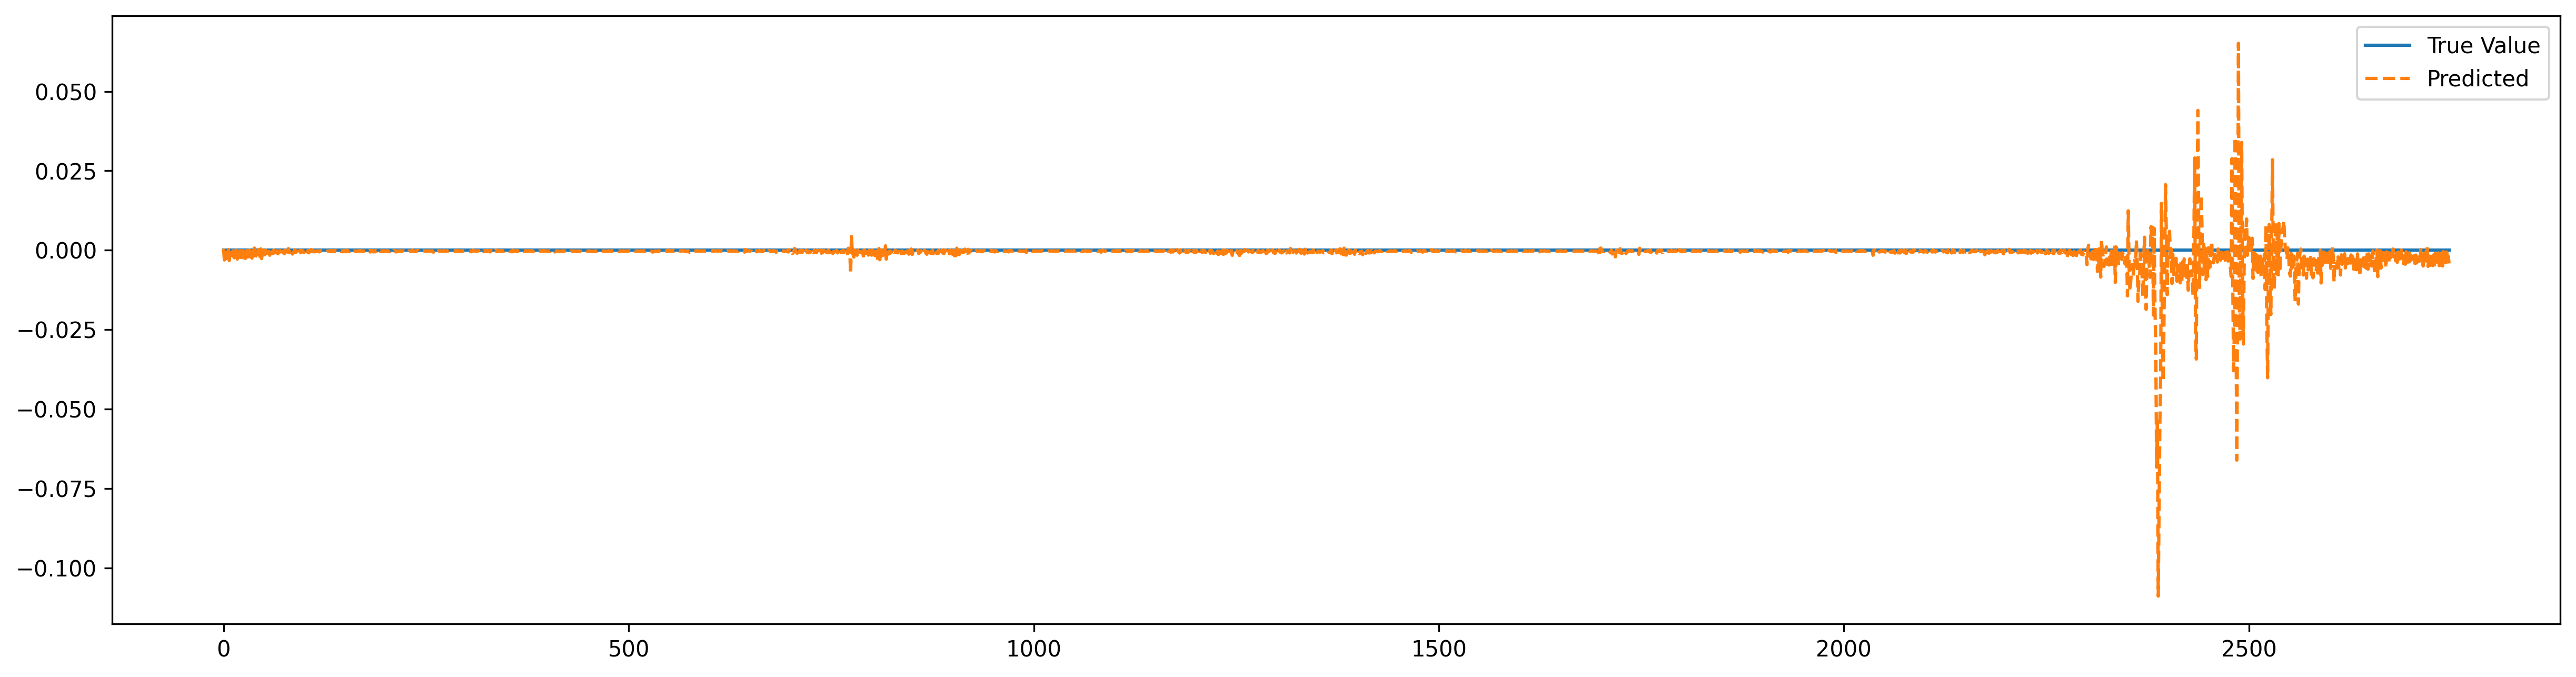

In [66]:
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_test,label='True Value')
plt.plot(pred,linestyle='--', label = 'Predicted')
plt.legend()
plt.show()

In [67]:
tb_mae = np.mean(np.abs(y_test - pred))
tb_mae

0.0014459936415776315

201/201 [==============================] - 0s 1ms/step


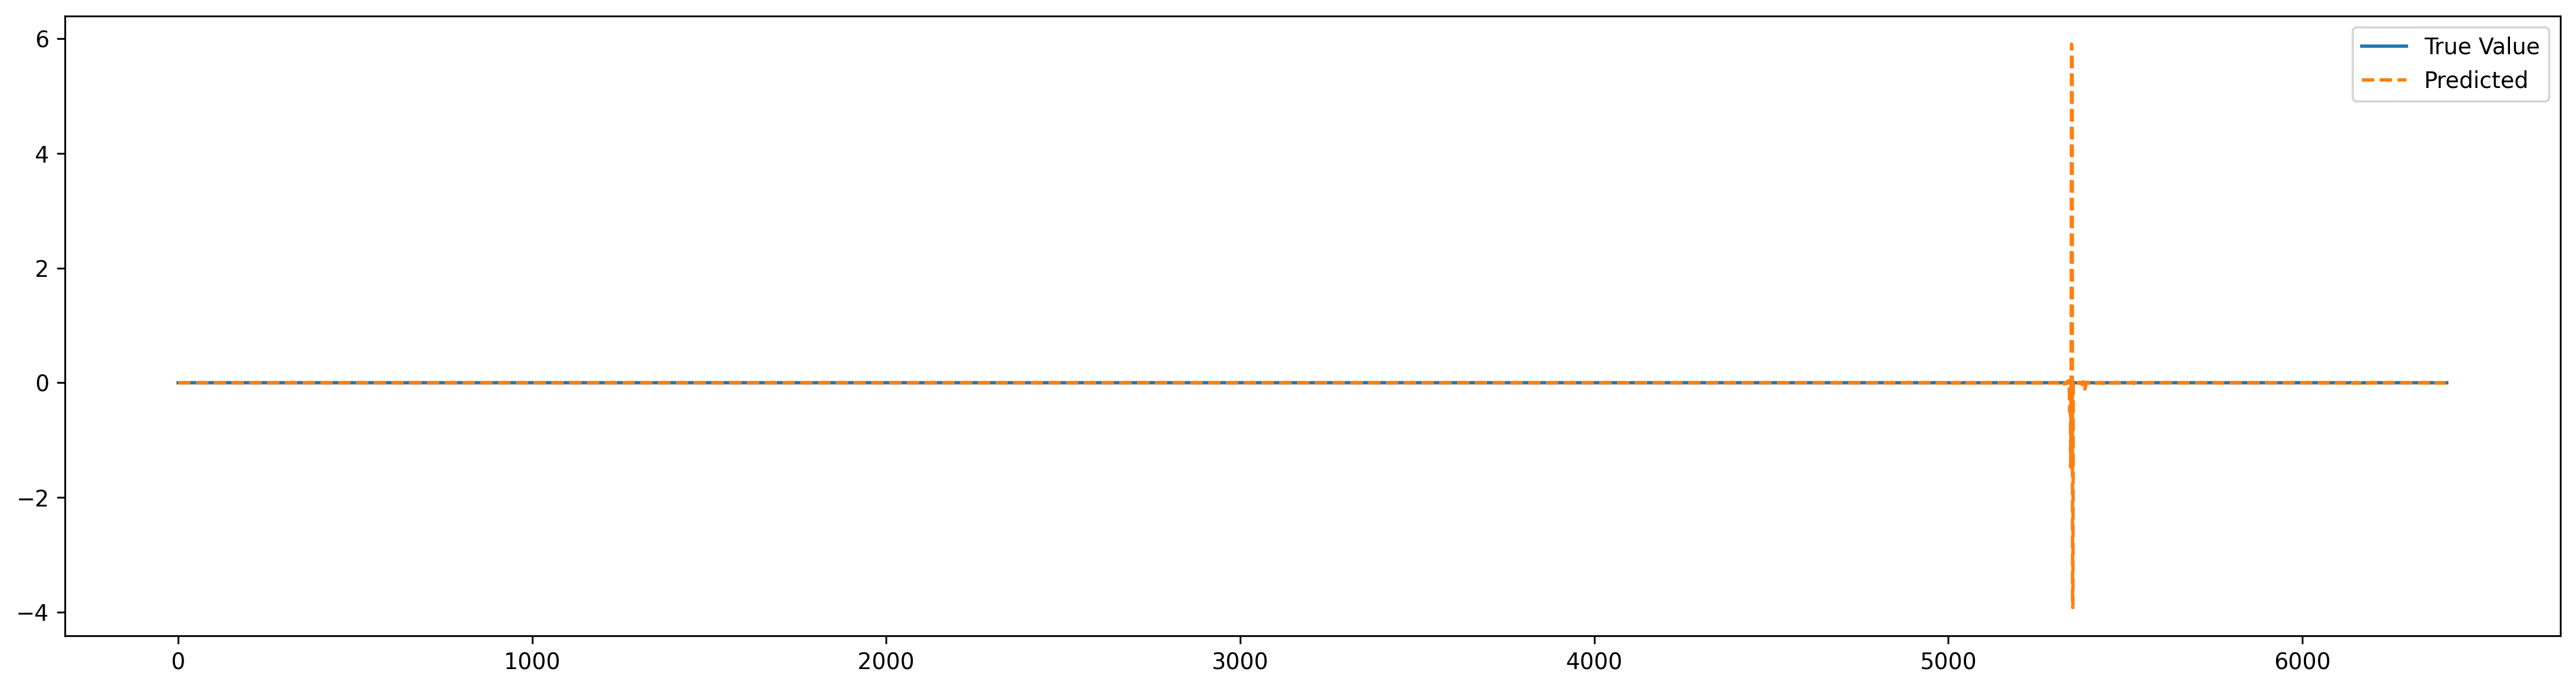

In [68]:
pred = model.predict(X_train)
plt.figure(figsize=(20,5),dpi=300)
plt.plot(y_train,label='True Value')
plt.plot(pred,linestyle='--', label = 'Predicted')
plt.legend()
plt.show()

In [69]:
model.evaluate(X_test, y_test), model.evaluate(X_train, y_train)

201/201 [==============================] - 0s 1ms/step - loss: 0.0209 - mape: 14230.8389


([2.6547810193733312e-05, 3821.0498046875],
 [0.02088553085923195, 14230.8388671875])

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 0.0000000008)
plt.show()

# Plot the next 5760

In [53]:
X_new.shape

(9157, 12, 10)

In [ ]:
X_new.shape

In [ ]:
# # Scale the input data using the same scaler used for training
# X_new_scaled = scaler.transform(X_new)

# # Reshape the input data to match the model's input shape
# X_new_reshaped = np.reshape(X_new_scaled, (X_new_scaled.shape[0], X_new_scaled.shape[1], 1))

# Predict the next 5760 y values
pred_5760 = model.predict(X_new[-5760:])

# # Inverse transform the scaled predictions to get the actual values
# pred_5760_actual = scaler.inverse_transform(pred_5760)

# Plot the predicted values
import matplotlib.pyplot as plt

# plt.plot(pred_5760_actual)
plt.plot(pred_5760)
plt.title("Predicted Volatility for Next 5760 Steps")
plt.xlabel("Step")
plt.ylabel("Volatility")
plt.show()


In [ ]:
pred_5760.shape

# GBRF

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# generate a random dataset for demonstration purposes
X, y = make_classification(n_samples=1000, n_features=10, random_state=42)

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# train a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# train a gradient boosting classifier on top of the random forest
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)

# evaluate the performance of the random forest and gradient boosting models
rf_preds = rf.predict(X_test)
gb_preds = gb.predict(X_test)

rf_acc = accuracy_score(y_test, rf_preds)
gb_acc = accuracy_score(y_test, gb_preds)

print("Random Forest Accuracy:", rf_acc)
print("Gradient Boosted Random Forest Accuracy:", gb_acc)


In [ ]:
pip install tensorflow_decision_forests

In [ ]:
pip install wurlitzer

In [ ]:
import tensorflow_decision_forests as tfdf

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import math

In [ ]:
tfdf.model_plotter.plot_model_in_colab(gb, tree_idx=0, max_depth=3)

In [ ]:
# Make predictions on the test set
y_pred_gb_rf = gb_preds
y_pred_rf = rf_preds

# Plot the predicted values against the true values
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_gb_rf, label='Gradient Boosted Random Forest')
ax.scatter(y_test, y_pred_rf, label='Random Forest')
ax.plot([0, 0.00008], [0, 0.008], 'k--')
ax.set_xlabel('True Values')
ax.set_ylabel('Predicted Values')
ax.legend()
plt.show()

# Testing optimal windows size

In [41]:
data

,log_price,scrape_time_interval,WAP,spread,log_returns,realized_volatility,volatility_t+1,bid depth,ask depth,ob_weighted_price,SMA,EMA,TWAP,price_level
0,10.257309,5.0,28490.008547,3.510004e-07,-2.331490e-05,0.000012,0.000011,5.83333,8.03665,28490.470408,28487.191667,28487.036802,28490.706029,28490.005
1,10.257309,4.0,28490.008529,3.510004e-07,-6.388916e-10,0.000011,0.000017,5.69514,9.36146,28490.421280,28487.236667,28487.074922,28490.663016,28490.005
2,10.257272,5.0,28488.951433,3.510137e-07,-3.710478e-05,0.000017,0.000016,4.88340,8.58175,28488.662534,28485.793333,28485.833148,28489.215474,28488.925
3,10.257270,4.0,28488.909106,3.510137e-07,-1.485751e-06,0.000016,0.000018,7.79497,10.60699,28489.021118,28485.626667,28485.701450,28489.045919,28488.925
4,10.257271,5.0,28488.943606,3.510137e-07,1.210985e-06,0.000018,0.000018,5.86444,10.07692,28489.112399,28485.700000,28485.739620,28489.030447,28488.925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9164,10.253968,4.0,28394.998642,3.521747e-07,1.027610e-06,0.000039,0.000039,7.99293,6.88169,28394.564486,28391.046667,28390.928959,28395.045599,28395.005
9165,10.253968,1.0,28394.998642,3.521747e-07,0.000000e+00,0.000039,0.000039,7.99293,6.88169,28394.564486,28391.046667,28390.928959,28395.045599,28395.005
9166,10.253968,4.0,28394.998162,3.521747e-07,-1.691898e-08,0.000039,0.000039,7.80102,6.75659,28394.561593,28391.417500,28391.262350,28394.945659,28395.005
9167,10.253967,0.0,28394.970149,3.521747e-07,-9.865364e-07,0.000039,0.000039,7.38509,6.75659,28394.466555,28391.050833,28390.931386,28394.922673,28395.005


In [43]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

# Define the sliding window function
def sliding_window(data, target_col, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length-1):
        X.append(data.iloc[i:(i+seq_length), :].values)
        y.append(data.iloc[i+seq_length, data.columns.get_loc(target_col)])
    return np.array(X), np.array(y)

# Define the LSTM model
def create_lstm_model(seq_length, n_features):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(seq_length, n_features)))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [47]:
# Load the data and split it into train, validation, and test sets

train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data))
test_size = len(data) - train_size - val_size
train_data = data.iloc[:train_size, :]
val_data = data.iloc[train_size:(train_size+val_size), :]
test_data = data.iloc[(train_size+val_size):, :]


In [48]:
# Set the range of window sizes to try
min_window_size = 10
max_window_size = 50

# Initialize variables for storing the best window size and best validation loss
best_window_size = -1
best_val_loss = float('inf')


In [49]:
# Loop over different window sizes and train LSTM models
for window_size in range(min_window_size, max_window_size+1):
    # Create the train and validation sets using the sliding window function
    X_train, y_train = sliding_window(train_data, 'volatility_t+1', window_size)
    X_val, y_val = sliding_window(val_data, 'volatility_t+1', window_size)

    # Create and train an LSTM model
    model = create_lstm_model(window_size, train_data.shape[1])
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

    # Evaluate the model on the validation set and store the validation loss
    val_preds = model.predict(X_val)
    val_loss = mean_squared_error(y_val, val_preds)

    # Update the best window size and best validation loss if necessary
    if val_loss < best_val_loss:
        best_window_size = window_size
        best_val_loss = val_loss

56/56 [==============================] - 0s 2ms/step


In [50]:
# Train a final model using the best window size and the combined train and validation sets
X_train_final, y_train_final = sliding_window(pd.concat([train_data, val_data]), 'volatility_t+1', best_window_size)
X_test, y_test = sliding_window(test_data, 'volatility_t+1', best_window_size)
model_final = create_lstm_model(best_window_size, train_data.shape[1])
model_final.fit(X_train_final, y_train_final, epochs=50, batch_size=32, verbose=0)

# Evaluate the final model on the test set
test_preds = model_final.predict(X_test)
test_loss = mean_squared_error(y_test, test_preds)
print("Best window size:", best_window_size)
print("Test loss:", test_loss)

28/28 [==============================] - 0s 2ms/step
Best window size: 46
Test loss: 5.571034218686186e-10


# Random Forest

In [71]:
data

,log_price,scrape_time_interval,WAP,spread,log_returns,realized_volatility,volatility_t+1,bid depth,ask depth,ob_weighted_price,SMA,EMA,TWAP,price_level
0,10.257309,5.0,28490.008547,3.510004e-07,-2.331490e-05,0.000012,0.000011,5.83333,8.03665,28490.470408,28487.191667,28487.036802,28490.706029,28490.005
1,10.257309,4.0,28490.008529,3.510004e-07,-6.388916e-10,0.000011,0.000017,5.69514,9.36146,28490.421280,28487.236667,28487.074922,28490.663016,28490.005
2,10.257272,5.0,28488.951433,3.510137e-07,-3.710478e-05,0.000017,0.000016,4.88340,8.58175,28488.662534,28485.793333,28485.833148,28489.215474,28488.925
3,10.257270,4.0,28488.909106,3.510137e-07,-1.485751e-06,0.000016,0.000018,7.79497,10.60699,28489.021118,28485.626667,28485.701450,28489.045919,28488.925
4,10.257271,5.0,28488.943606,3.510137e-07,1.210985e-06,0.000018,0.000018,5.86444,10.07692,28489.112399,28485.700000,28485.739620,28489.030447,28488.925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9164,10.253968,4.0,28394.998642,3.521747e-07,1.027610e-06,0.000039,0.000039,7.99293,6.88169,28394.564486,28391.046667,28390.928959,28395.045599,28395.005
9165,10.253968,1.0,28394.998642,3.521747e-07,0.000000e+00,0.000039,0.000039,7.99293,6.88169,28394.564486,28391.046667,28390.928959,28395.045599,28395.005
9166,10.253968,4.0,28394.998162,3.521747e-07,-1.691898e-08,0.000039,0.000039,7.80102,6.75659,28394.561593,28391.417500,28391.262350,28394.945659,28395.005
9167,10.253967,0.0,28394.970149,3.521747e-07,-9.865364e-07,0.000039,0.000039,7.38509,6.75659,28394.466555,28391.050833,28390.931386,28394.922673,28395.005
